# Draft. This jupyter notebook was used to review data files and try to learn insights from the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb 

from focal_loss import FocalLoss
from SimpleModel_dev import BoostingModel_dev
from aux_functions import prepare_data, prepare_data_dev

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_FOLDER = 'idao_2021_train/'

In [4]:
df_funnel = pd.read_csv(DATA_FOLDER + 'funnel.csv')
N_SAMPLES = len(df_funnel)

### data

In [5]:
# train_data, metric_data = prepare_data_dev(DATA_FOLDER)
train_data, metric_data = prepare_data_dev(DATA_FOLDER)
metric_data.sale_amount = metric_data.sale_amount.fillna(0)
X = train_data.drop(columns=['sale_flg'])
y = train_data['sale_flg']

/Users/yaourt/miniconda3/envs/idao/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
split_fr = 0.2
X_train, X_test, y_train, y_test, metric_data_train, metric_data_test = train_test_split(X, y, metric_data, test_size=split_fr, random_state=42)       

### fit

In [7]:
fl = FocalLoss(alpha=.99, gamma=1.01)

In [8]:
model = BoostingModel_dev(fl)
# model = BoostingModel_dev()
# model.fit(X, y, 1, 1e8)
model.fit(X_train, y_train, 1000, 1, 1, X_test, y_test, early_stopping=30)

/Users/yaourt/miniconda3/envs/idao/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.659722	valid_0's focal_loss: 0.117585
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.665896	valid_0's focal_loss: 0.104035
[3]	valid_0's auc: 0.678952	valid_0's focal_loss: 0.0924255
[4]	valid_0's auc: 0.685585	valid_0's focal_loss: 0.0824748
[5]	valid_0's auc: 0.687458	valid_0's focal_loss: 0.0738439
[6]	valid_0's auc: 0.68835	valid_0's focal_loss: 0.0664608
[7]	valid_0's auc: 0.691595	valid_0's focal_loss: 0.0600918
[8]	valid_0's auc: 0.694777	valid_0's focal_loss: 0.0545417
[9]	valid_0's auc: 0.696347	valid_0's focal_loss: 0.0497327
[10]	valid_0's auc: 0.696054	valid_0's focal_loss: 0.0455014
[11]	valid_0's auc: 0.696398	valid_0's focal_loss: 0.0417607
[12]	valid_0's auc: 0.696282	valid_0's focal_loss: 0.0384974
[13]	valid_0's auc: 0.696262	valid_0's focal_loss: 0.03566
[14]	valid_0's auc: 0.697771	valid_0's focal_loss: 0.0331858
[15]	valid_0's auc: 0.695671	valid_0's focal_loss: 0.0310099
[16]	valid_0's auc: 0.701297	valid_0's

### evaluate

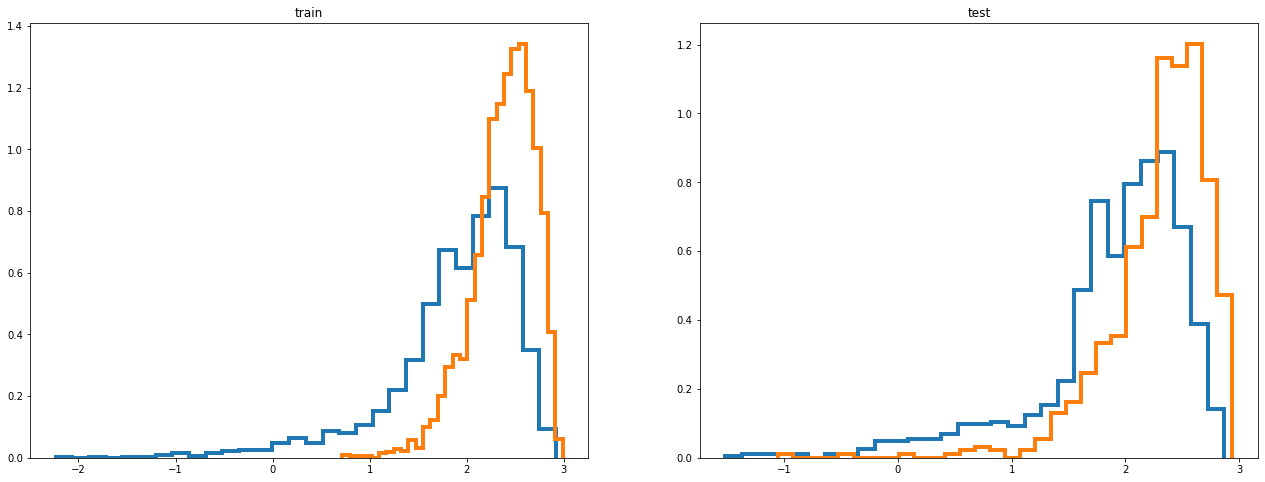

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(22, 8))
axs[0].hist(model.predict(X_train)[y_train==0], bins=30, density=True, histtype='step', linewidth=4)#, range=(0., 1.1))
axs[0].hist(model.predict(X_train)[y_train==1], bins=30, density=True, histtype='step', linewidth=4)#, range=(0., 1.1))
axs[0].set_title('train')
axs[1].hist(model.predict(X_test)[y_test==0], bins=30, density=True, histtype='step', linewidth=4)#, range=(0., 1.1) )
axs[1].hist(model.predict(X_test)[y_test==1], bins=30, density=True, histtype='step', linewidth=4)#, range=(0., 1.1) )
axs[1].set_title('test')
plt.show()

In [10]:
# thr = 1-1e-5
thr = 0.1

In [11]:
# for thr in [0.001, 0.005, 0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4]:
for thr in [thr]:
    y_train_pred = model.predict(X_train) > thr
    y_test_pred = model.predict(X_test) > thr
    y_pred = model.predict(X) > thr
    nic_train = sum(y_train_pred*metric_data_train.sale_amount - 4000*metric_data_train.contacts) / ((1-split_fr)*N_SAMPLES)
    nic_test = sum(y_test_pred*metric_data_test.sale_amount - 4000*metric_data_test.contacts) / ((split_fr)*N_SAMPLES)
    nic = sum(y_pred*metric_data.sale_amount - 4000*metric_data.contacts) / N_SAMPLES
    print(thr, ': ', nic_train, nic_test, nic)

0.1 :  5301.46207496045 5353.183970601915 5311.806454088753
